In [1]:
%load_ext autoreload
%autoreload 2

# Simulate Using Building Co-Simulation Model

In [2]:
import os, pickle, sys

# import gym, eplus_env

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from simulate_model import Model

In [3]:
# Generate a sample agent doing nothing
class Agent:
    def __init__(self):
        self.current_timestep = 0

    # Must have this function to interact with energyplus
    # State is the current state
    def step(self, state):
        print(f"Timestep: {self.current_timestep}\nState: {state}")
        self.current_timestep += 1

In [4]:
idf = 'eplus_files/5Zone_Default_93.idf'
epw = 'eplus_files/pittsburgh_TMY3.epw'

Model.set_energyplus_folder("/usr/local/EnergyPlus-9-3-0/")

ep_model = Model(idf_file_name=idf,
                 weather_file=epw,
                 agent=Agent())

In [ ]:
ep_model.simulate()

EnergyPlus Starting
EnergyPlus, Version 9.3.0-baff08990c, YMD=2022.03.17 14:52
Initializing Response Factors
Calculating CTFs for "ROOF-1", Construction # 1
Calculating CTFs for "WALL-1", Construction # 2
Calculating CTFs for "FLOOR-SLAB-1", Construction # 6
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Computing Interior Diffuse Solar Absorption Factors
Computing Interior Diffuse Solar Exchange through Interzone Windows
Initializing Solar Heat Gains
Initiali

In [9]:
df = pd.DataFrame(ep_model.state_history)
df.index = pd.to_datetime(df[['year', 'month', 'day', 'hour', 'minute']])
df.head()

,Outdoor Temp.,Outdoor RH,Wind Speed,Wind Direction,Diff. Solar Rad.,Direct Solar Rad.,Indoor Temp.,Htg SP,Clg SP,Indoor Temp. Setpoint,...,Sys In Mdot,MA Temp.,MA Mdot,OA Temp,OA Mdot,year,month,day,hour,minute
1991-01-01 00:00:00,0.0,95.00,4.1,290.0,0.0,0.0,13.535827,12.8,40.0,12.8,...,1.696378,11.920788,1.696378,0.0,0.271078,1991,1,1,0,0
1991-01-01 00:15:00,1.8,95.25,4.1,265.0,0.0,0.0,13.535827,12.8,40.0,12.8,...,1.696378,11.920788,1.696378,0.0,0.271078,1991,1,1,0,15
1991-01-01 00:30:00,3.6,95.50,4.1,240.0,0.0,0.0,13.523141,12.8,40.0,12.8,...,1.696378,12.080149,1.696378,1.8,0.271078,1991,1,1,0,30
1991-01-01 00:45:00,5.4,95.75,4.1,215.0,0.0,0.0,13.593976,12.8,40.0,12.8,...,1.696378,12.246436,1.696378,3.6,0.271078,1991,1,1,0,45
1991-01-01 01:00:00,7.2,96.00,4.1,190.0,0.0,0.0,13.674776,12.8,40.0,12.8,...,1.049370,11.615393,1.049370,5.4,0.271078,1991,1,1,0,60


# Plot

In [10]:
def plotBaseline(baseline):
    fig = plt.figure(figsize=(20,6))

    plt.subplot(2,1,1)
    plt.plot(baseline["Indoor Temp."], 'b-', label="EnergyPlus")
    plt.plot(baseline["Indoor Temp. Setpoint"], 'k--')
    plt.legend()
    plt.ylabel("State\nIndoor Temp.", fontsize = 16)

    plt.subplot(2,1,2)
    plt.plot(baseline["Sys Out Temp."],'b', label ="EnergyPlus")
    plt.plot(baseline["Occupancy Flag"]*30, 'k--', label= "Occupancy Flag")
    plt.ylabel("Action\nSupply Air Temp.", fontsize = 16)
    plt.legend()

/Users/Gaby/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


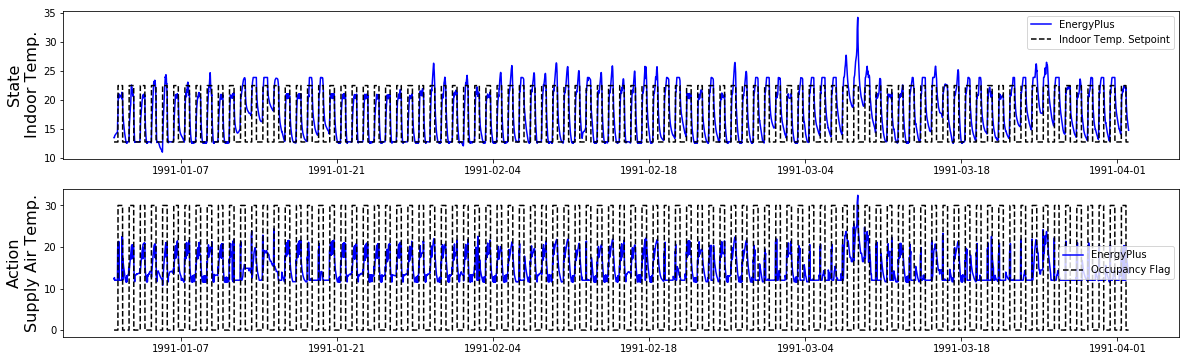

In [11]:
plotBaseline(df)

# Save

In [12]:
dist_name = ["Indoor Temp. Setpoint", "Outdoor Temp.", "Outdoor RH", "Wind Speed", "Wind Direction", "Diff. Solar Rad.", "Direct Solar Rad.", "Occupancy Flag"]
# "Indoor Temp. Setpoint",   TODO indoor temp setpoint not in output variables right now ... this is probably pretty important
# once this is figured out it should be added back to the dist_name list

dist_df = df[dist_name]

results_dir = 'simulation_results'

if not os.path.exists(results_dir):
    os.mkdir(results_dir)

df.to_pickle(os.path.join(results_dir, "Sim-TMY3.pkl"))
dist_df.to_pickle(os.path.join(results_dir, "Dist-TMY3.pkl"))
print("Saved!")

Saved!


  <variable source="EnergyPlus">
   <EnergyPlus name="Environment" type="Site Outdoor Air Drybulb Temperature"/>
  </variable>
  
  <variable source="EnergyPlus">
   <EnergyPlus name="Environment" type="Site Outdoor Air Relative Humidity"/>
  </variable>
  
  <variable source="EnergyPlus">
   <EnergyPlus name="Environment" type="Site Wind Speed"/>
  </variable>
  
  <variable source="EnergyPlus">
   <EnergyPlus name="Environment" type="Site Wind Direction"/>
  </variable>
  
  <variable source="EnergyPlus">
   <EnergyPlus name="Environment" type="Site Diffuse Solar Radiation Rate per Area"/>
  </variable>
    
  <variable source="EnergyPlus">
   <EnergyPlus name="Environment" type="Site Direct Solar Radiation Rate per Area"/>
  </variable>

<!--Setpoints--> 
  <variable source="EnergyPlus">
   <EnergyPlus name="SPACE1-1" type="Zone Thermostat Heating Setpoint Temperature"/>
  </variable>

  <variable source="EnergyPlus">
   <EnergyPlus name="SPACE1-1" type="Zone Thermostat Cooling Setpoint Temperature"/>
  </variable> 
  
<!--Zone--> 
  <variable source="EnergyPlus">
   <EnergyPlus name="EMS" type="Building Mean Temperature"/>
  </variable>

 <variable source="EnergyPlus">
   <EnergyPlus name="EMS" type="Indoor Air Temperature Setpoint"/>
  </variable>

<!--Occupants--> 
  <variable source="EnergyPlus">
   <EnergyPlus name="EMS" type="Building Mean PPD"/>
  </variable>
  
   <variable source="EnergyPlus">
   <EnergyPlus name="EMS" type="Occupancy Flag"/>
  </variable>
 
<!-- Energy Consumption --> 
  <variable source="EnergyPlus">
   <EnergyPlus name="Main Heating Coil 1" type="Heating Coil Electric Power"/>
  </variable>

  <variable source="EnergyPlus">
   <EnergyPlus name="Whole Building" type="Facility Total HVAC Electric Demand Power"/>
  </variable>

<!-- HVAC --> 
 <variable source="EnergyPlus">
   <EnergyPlus name="VAV SYS 1 Inlet NODE" type="System Node Temperature"/>
  </variable>
  
  <variable source="EnergyPlus">
   <EnergyPlus name="VAV SYS 1 Inlet NODE" type="System Node Mass Flow Rate"/>
  </variable>

 <variable source="EnergyPlus">
   <EnergyPlus name="Outside Air Inlet Node 1" type="System Node Temperature"/>
  </variable>
  
  <variable source="EnergyPlus">
   <EnergyPlus name="Outside Air Inlet Node 1" type="System Node Mass Flow Rate"/>
  </variable>

 <variable source="EnergyPlus">
   <EnergyPlus name="Mixed Air Node 1" type="System Node Temperature"/>
  </variable>
  
  <variable source="EnergyPlus">
   <EnergyPlus name="Mixed Air Node 1" type="System Node Mass Flow Rate"/>
  </variable>

 <variable source="EnergyPlus">
   <EnergyPlus name="VAV SYS 1 OUTLET NODE" type="System Node Temperature"/>
  </variable>
  
  <variable source="EnergyPlus">
   <EnergyPlus name="VAV SYS 1 OUTLET NODE" type="System Node Mass Flow Rate"/>
  </variable>